# **LOAD DATASET & LIBRARY**

In [ ]:
pip install nltk


In [ ]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 12.0 MB/s eta 0:00:00


In [ ]:
import spacy
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm


from spacy import displacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader , TensorDataset
from torchsummary import summary
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

lemma = WordNetLemmatizer()
lb = LabelEncoder()
nlp=spacy.load("en_core_web_lg")

In [ ]:
dataset = pd.read_excel('/content/dataset.xls')
dataset.head()

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Mon Dec 04 12:01:29 +0000 2023,1731640000000000000,"Menurut laporan BPS, Sumatra Utara menjadi pro...",0,0,0,0,in,1316330000000000000,1731640000000000000,databoksid,https://twitter.com/databoksid/status/17316448...
1,Fri Dec 01 08:00:00 +0000 2023,1730500000000000000,"Diguyur hujan deras, jalan di Lebak, Banten, l...",0,0,0,0,in,61377303,1730500000000000000,Lintas_MNCTV,https://twitter.com/Lintas_MNCTV/status/173049...
2,Fri Dec 01 06:14:11 +0000 2023,1730470000000000000,"Bapak/ibu, terdpt jalan yang rusak di daerah G...",0,1,1,0,in,1574830000000000000,1730470000000000000,Eddy30749724,https://twitter.com/Eddy30749724/status/173047...
3,Fri Dec 01 05:42:40 +0000 2023,1730460000000000000,"Catatan infrastruktur jalan di Indonesia, berd...",0,1,30,30,in,53878998,1730460000000000000,datanesia_id,https://twitter.com/datanesia_id/status/173046...
4,Tue Nov 28 03:50:18 +0000 2023,1729350000000000000,Jenazah pria bernama Arju (45) di Polewali Man...,0,0,0,1,in,375995332,1729350000000000000,SeputariNews,https://twitter.com/SeputariNews/status/172934...


In [ ]:
dataset.isnull().sum()

created_at             0
id_str                 0
full_text              5
quote_count            0
reply_count            0
retweet_count          0
favorite_count         0
lang                   0
user_id_str            0
conversation_id_str    0
username               0
tweet_url              0
dtype: int64

In [ ]:
dataset_cleaned_rows = dataset.dropna()
dataset_cleaned_columns = dataset.dropna(axis=1)

# **PRE PROCESSING** #

In [ ]:
def Most_Words_used(full_text , num_of_words) :
    all_text = ''.join(dataset[full_text].values)

    all_text = re.sub(r'http\S+', '', all_text)
    all_text = re.sub(r'@\S+', '', all_text)
    all_text = re.sub(r'#\S+', '', all_text)
    all_text = re.sub(r'\d+', '',all_text)
    all_text = re.sub(r'[^\w\s]', '',all_text)


    words = all_text.split()

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]

    word_counts = Counter(words)

    top_words = word_counts.most_common(num_of_words)

    return top_words

In [ ]:
def DataPrep(full_text) :
    full_text = re.sub('<.*?>', '', full_text)
    full_text = re.sub(r'http\S+', '', full_text)
    full_text = re.sub(r'@\S+', '', full_text)
    full_text = re.sub(r'#\S+', '', full_text)
    full_text = re.sub(r'\d+', '', full_text)
    full_text = re.sub(r'[^\w\s]', '', full_text)
    full_text = re.sub(r'@(\w+)', '', full_text)

    tokens = nltk.word_tokenize(full_text)

    #remove puncs
    punc = list(punctuation)
    words = [w for w in tokens if w not in punc]

    #remove stop words
    stop_words = set(stopwords.words('english'))
    words = [w.lower() for w in words if not w.lower() in stop_words]

    # lemmatization
    words = [lemma.lemmatize(w) for w in words]

    text = ' '.join(words)

    return text

In [ ]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
dataset['full_text'] = dataset['full_text'].astype(str).apply(DataPrep)


In [ ]:
print(dataset['full_text'])

0       menurut laporan bps sumatra utara menjadi prov...
1       diguyur hujan deras jalan di lebak banten long...
2       bapakibu terdpt jalan yang rusak di daerah gra...
3       catatan infrastruktur jalan di indonesia berda...
4       jenazah pria bernama arju di polewali mandar t...
                              ...                        
6054    orang jawa solo ewuh pekewuh dan tidak mau the...
6055    kak maaf oot mau nanya apakah memang di pedala...
6056    ï sedangkan pada rambut dan kuku tidak ada lag...
6057    berangkat dari meeting informal tersebut bayer...
6058    testimoni hari ini yang punya masalah sinyal j...
Name: full_text, Length: 6059, dtype: object


In [ ]:
print(f'There are around {int(dataset["full_text"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 540 duplicated tweets, we will remove them.


In [ ]:
dataset.drop_duplicates("full_text", inplace=True)

In [ ]:
print(f'There are around {int(dataset["full_text"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 0 duplicated tweets, we will remove them.


# **VADER LABELLING** #

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [ ]:
# Inisialisasi VADER
sia = SentimentIntensityAnalyzer()

# Fungsi untuk menentukan kategori urgent atau tidak urgent berdasarkan sentimen
def categorize_sentiment(row, urgent_words=None):
    sentiment_scores = sia.polarity_scores(row['full_text'])

    # Jika terdapat kata-kata tertentu dalam kalimat, kategorikan sebagai 'urgent'
    if urgent_words and any(word in row['full_text'] for word in urgent_words):
        return 'mendesak'
    # Jika nilai sentimen negatif lebih tinggi, kategorikan sebagai 'urgent'
    elif sentiment_scores['neg'] > sentiment_scores['pos']:
        return 'mendesak'
    else:
        return 'tidak mendesak'

# Terapkan fungsi pada setiap baris data untuk menentukan kategori
# Di sini, kita memberikan daftar kata-kata mendesak sebagai contoh, Anda dapat mengubahnya sesuai kebutuhan
urgent_keywords = ["mendesak", "darurat", "penting", "lagi", "mati", "jenazah", "mayat"]
dataset['label'] = dataset.apply(lambda row: categorize_sentiment(row, urgent_words=urgent_keywords), axis=1)

# Tampilkan data yang telah ditambahkan kategori urgent atau tidak urgent
print(dataset[['full_text', 'label']])

                                              full_text           label
0     menurut laporan bps sumatra utara menjadi prov...  tidak mendesak
1     diguyur hujan deras jalan di lebak banten long...  tidak mendesak
2     bapakibu terdpt jalan yang rusak di daerah gra...  tidak mendesak
3     catatan infrastruktur jalan di indonesia berda...  tidak mendesak
4     jenazah pria bernama arju di polewali mandar t...        mendesak
...                                                 ...             ...
6054  orang jawa solo ewuh pekewuh dan tidak mau the...  tidak mendesak
6055  kak maaf oot mau nanya apakah memang di pedala...  tidak mendesak
6056  ï sedangkan pada rambut dan kuku tidak ada lag...        mendesak
6057  berangkat dari meeting informal tersebut bayer...  tidak mendesak
6058  testimoni hari ini yang punya masalah sinyal j...        mendesak

[5519 rows x 2 columns]


In [ ]:
dataset['label'].value_counts()

tidak mendesak    3107
mendesak          2412
Name: label, dtype: int64

In [ ]:
!pip install xlwt

# Simpan dataframe yang sudah dilabeli ke file Excel
labeled_file_path = 'data_twitter_labeled.xls'  # Ubah ekstensi file sesuai kebutuhan, misalnya .xls atau .xlsx
dataset.to_excel(labeled_file_path, index=False)

# Berikan tautan untuk mengunduh file labeled Excel
download_link = f'<a href="{labeled_file_path}" download>Klik di sini</a> untuk mengunduh file labeled Excel.'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 780.3 kB/s eta 0:00:00


In [ ]:
from google.colab import files

files.download('data_twitter_labeled.xls')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **LOAD DATASET LABELED**

In [ ]:
pip install rank_bm25

In [ ]:
import pandas as pd
#preprocesing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
#split data
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
# mb25
from rank_bm25 import BM25Okapi
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
dataset_label = pd.read_excel('/content/data_twitter_labeled.xls')
dataset_label.head()

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,label
0,Mon Dec 04 12:01:29 +0000 2023,1731640000000000000,menurut laporan bps sumatra utara menjadi prov...,0,0,0,0,in,1316330000000000000,1731640000000000000,databoksid,https://twitter.com/databoksid/status/17316448...,tidak mendesak
1,Fri Dec 01 08:00:00 +0000 2023,1730500000000000000,diguyur hujan deras jalan di lebak banten long...,0,0,0,0,in,61377303,1730500000000000000,Lintas_MNCTV,https://twitter.com/Lintas_MNCTV/status/173049...,tidak mendesak
2,Fri Dec 01 06:14:11 +0000 2023,1730470000000000000,bapakibu terdpt jalan yang rusak di daerah gra...,0,1,1,0,in,1574830000000000000,1730470000000000000,Eddy30749724,https://twitter.com/Eddy30749724/status/173047...,tidak mendesak
3,Fri Dec 01 05:42:40 +0000 2023,1730460000000000000,catatan infrastruktur jalan di indonesia berda...,0,1,30,30,in,53878998,1730460000000000000,datanesia_id,https://twitter.com/datanesia_id/status/173046...,tidak mendesak
4,Tue Nov 28 03:50:18 +0000 2023,1729350000000000000,jenazah pria bernama arju di polewali mandar t...,0,0,0,1,in,375995332,1729350000000000000,SeputariNews,https://twitter.com/SeputariNews/status/172934...,mendesak


# **SPLIT DATASET (80:20)**

In [ ]:
# Membuat DataFrame dari data sentimen
dataset_label = pd.DataFrame(dataset_label)

In [ ]:
X = dataset_label['full_text'].tolist()
y = dataset_label['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Jumlah data latih
num_train = len(X_train)
print("Jumlah data latih:", num_train)

# Jumlah data uji
num_test = len(X_test)
print("Jumlah data uji:", num_test)

Jumlah data latih: 4415
Jumlah data uji: 1104


In [ ]:
dataset = dataset_label.dropna(subset=['full_text'])

# Extract the 'text' column as a list again
X_train = dataset['full_text'].tolist()

# Define n-gram range
ngram_range = (1, 2)

# Initialize CountVectorizer
vectorizer = CountVectorizer(ngram_range=ngram_range)

# Fit and transform the data
X_train_counts = vectorizer.fit_transform(X_train)

In [ ]:
df_counts = pd.DataFrame(X_train_counts.toarray(), columns=vectorizer.get_feature_names_out())
print(df_counts)

      __  __ xl  ___  ___ habis  ____  _____  ______  _________  _a  aa  ...  \
0      0      0    0          0     0      0       0          0   0   0  ...   
1      0      0    0          0     0      0       0          0   0   0  ...   
2      0      0    0          0     0      0       0          0   0   0  ...   
3      0      0    0          0     0      0       0          0   0   0  ...   
4      0      0    0          0     0      0       0          0   0   0  ...   
...   ..    ...  ...        ...   ...    ...     ...        ...  ..  ..  ...   
5513   0      0    0          0     0      0       0          0   0   0  ...   
5514   0      0    0          0     0      0       0          0   0   0  ...   
5515   0      0    0          0     0      0       0          0   0   0  ...   
5516   0      0    0          0     0      0       0          0   0   0  ...   
5517   0      0    0          0     0      0       0          0   0   0  ...   

      ðÿƒ im  ðÿƒ sinyalnya  ðÿƒðÿââïðÿ

# **BM25**

In [ ]:
# Membangun BM25 Vectorizer
bm25 = BM25Okapi(X_train)

# Mengubah data pelatihan menjadi vektor BM25
X_train_bm25 = [bm25.get_scores(doc) for doc in X_train]

# Mengubah data uji menjadi vektor BM25
X_test_bm25 = [bm25.get_scores(doc) for doc in X_test]

# Menggabungkan X_train_bm25 dan X_test_bm25
X_train_bm25_combined = np.vstack(X_train_bm25)
X_test_bm25_combined = np.vstack(X_test_bm25)


# **WORD EMBEDDING**

In [ ]:
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [ ]:
# Melatih model Word2Vec
tokenized_text = dataset['full_text'].apply(lambda x: word_tokenize(x.lower()))
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, sg=0)

In [ ]:
# Membuat fungsi untuk mengonversi teks menjadi representasi vektor Word2Vec
def text_to_vector(text, model):
    words = word_tokenize(text.lower())
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        text_vector = sum(word_vectors) / len(word_vectors)
    else:
        text_vector = [0] * model.vector_size
    return text_vector

In [ ]:
# Mengonversi teks menjadi representasi vektor Word2Vec
dataset['text_vectors'] = dataset['full_text'].apply(lambda x: text_to_vector(x, word2vec_model))


# **MODELLING**

In [ ]:
# Memisahkan dataset menjadi data latih dan data uji
X = dataset['text_vectors'].tolist()  # Features
y = dataset['label']  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model1 = LogisticRegression()
model2 = DecisionTreeClassifier()
model3 = RandomForestClassifier()
model4 = SVC(probability=True)

ensemble_model = VotingClassifier(estimators=[('lr', model1), ('dt', model2), ('rf', model3), ('svm', model4)], voting='soft')

ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('dt', DecisionTreeClassifier()),
                             ('rf', RandomForestClassifier()),
                             ('svm', SVC(probability=True))],
                 voting='soft')

In [ ]:
# Membuat prediksi dengan model ensemble pada data uji
y_pred_ensemble = ensemble_model.predict(X_test)
y_pred_proba_ensemble = ensemble_model.predict_proba(X_test)

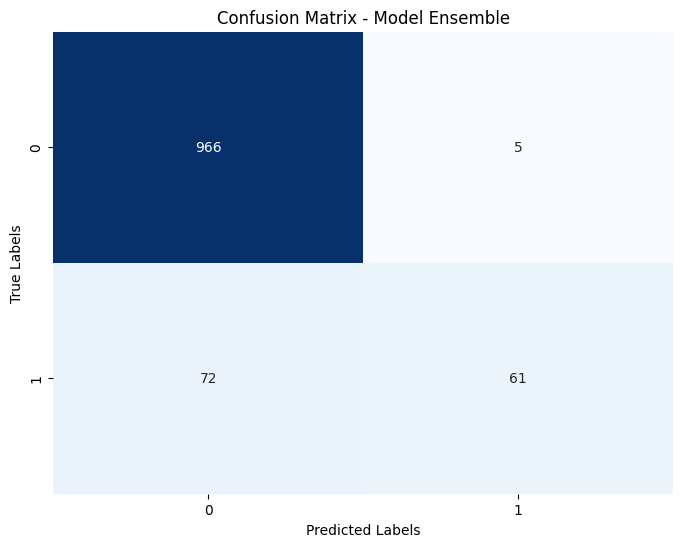

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns





# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_ensemble)


# Membuat heatmap dari confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Model Ensemble")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Mengubah y_pred_ensemble menjadi array numpy
y_pred_ensemble = np.array(y_pred_ensemble)

# Memastikan jumlah sampel yang konsisten
min_len = min(len(y_test), len(y_pred_ensemble))
y_test = y_test[:min_len]
y_pred_ensemble = y_pred_ensemble[:min_len]

# Menampilkan metrik evaluasi
accuracy = accuracy_score(y_test, y_pred_ensemble)
precision = precision_score(y_test, y_pred_ensemble, average='weighted')
recall = recall_score(y_test, y_pred_ensemble, average='weighted')
f1 = f1_score(y_test, y_pred_ensemble, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9302536231884058
Precision: 0.9298656170907366
Recall: 0.9302536231884058
F1-score: 0.9196754171808393
